## Задание

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm

from multipy.fwer import holm_bonferroni, bonferroni
from statsmodels.stats.multitest import multipletests

## 1. Подготовка данных

In [2]:
users_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', sep=';')

transactions_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', sep=';',
                                     parse_dates=['joined_at', 'paid_at']).dropna(axis='index', how='any', subset=['uid'])

transactions_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', sep=';',
                                     parse_dates=['joined_at', 'paid_at']).dropna(axis='index', how='any', subset=['uid'])

users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', sep=';')

transactions_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', sep=';',
                                parse_dates=['joined_at', 'paid_at'])

users_control_1.sample(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1680,892290495,31,0,NaN,Italy,"2,3",1,25,45,0,NaN,NaN,0
356,892068960,34,299,NaN,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,2...",1,31,37,127,NaN,NaN,0
1823,891235356,32,666,NaN,Chile,"1,2,3,4,6,7,8,9",1,21,32,6,NaN,NaN,0
858,892367031,24,428,NaN,United Kingdom (Great Britain),"1,2,3,4,5,6",1,21,27,28,NaN,NaN,0
2663,891466671,48,0,NaN,Argentina,"1,2,3,4",1,18,42,0,NaN,NaN,0


Соединим попарно данные о плательщиках во всех трех группах.

In [3]:
transactions_control_1.uid = transactions_control_1.uid.astype(int)
transactions_control_2.uid = transactions_control_2.uid.astype(int)

In [4]:
res_control_1 = pd.merge(transactions_control_1, users_control_1, how="left", on=["uid", "uid"])
res_control_2 = pd.merge(transactions_control_2, users_control_2, how="left", on=["uid", "uid"])
res_test = pd.merge(transactions_test, users_test, how="left", on=["uid", "uid"])
res_control_1.sample(5)

,uid,country_x,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
213,891662499,United Kingdom (Great Britain),2017-10-30 00:57:00,2017-10-11 19:42:00,3783.0,67.0,fans,other_type,38,212,NaN,United Kingdom (Great Britain),"1,2,4,5,6,7,9,10,11,12,13,14,15,16",1,18,38,559,1.0,1.0,10075
110,891174534,Argentina,2017-08-11 07:19:00,2017-11-15 09:19:00,10517.0,147.0,trial_vip_popup,trial_premium,49,0,NaN,Argentina,NaN,1,46,52,0,1.0,1.0,10517
228,891264903,United States of America,2017-06-11 16:02:00,2017-08-11 22:32:00,3887.0,147.0,none,premium_no_trial,19,239,NaN,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761
14,892277877,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897.0,19.0,empty_likes,coins,20,198,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,2...",1,17,23,116,1.0,1.0,13611
136,891937230,Canada,2017-10-24 14:17:00,2017-10-26 20:29:00,6305.0,19.0,autorefill,coins,40,200,8.0,Canada,"1,2,3,4,5,6,7,8,9,10,15",1,36,42,204,1.0,1.0,29081


In [5]:
del res_control_1['country_x']
del res_control_2['country_x']
del res_test['country_x']

In [6]:
res_test.query('revenue != 0 and total_revenue == 0').shape[0]

0

In [7]:
res_control_1.query('revenue != 0 and total_revenue == 0').shape[0]

1

В ходе проверки данных был обнаружен пользователь, производивший транзакции, но не имеющий записи о нормированной выручке.

In [8]:
# исправил значение total_revenue пользователю, запись о транзакции одна, значит по идее ей и равна total_revenue
res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'total_revenue'] = res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'revenue']
res_control_1[res_control_1.uid == 892355163]

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
303,892355163,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,30264.0


## 2. А/А-тест

Т.к. даны две контрольные группы, мы имеем возможность провести A/A-тест для проверки системы сплитования.

Используем для этого значения величин транзакций и нормированной выручки.

In [9]:
def get_AA(df1, df2):
    
    simulations = 1000
    n_s = 100
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = df1.sample(n_s, replace=False).values
        s2 = df2.sample(n_s, replace=False).values
        res.append(stats.ttest_ind(s1, s2, equal_var=False)[1]) # сохраняем pvalue

    plt.hist(res, bins=50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    
    return sum(np.array(res) < 0.05) / simulations 

  0%|          | 0/1000 [00:00<?, ?it/s]

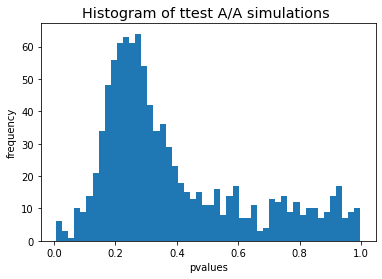

0.009

In [10]:
get_AA(res_control_1.drop_duplicates(subset='uid').total_revenue,
       res_control_2.drop_duplicates(subset='uid').total_revenue)

Тест по нормированной выручке "сошёлся".

  0%|          | 0/1000 [00:00<?, ?it/s]

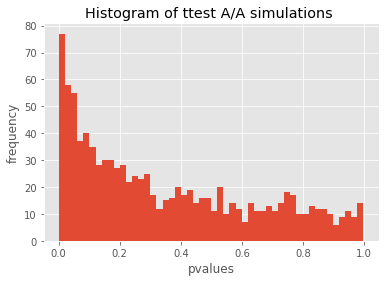

0.165

In [11]:
get_AA(res_control_1['revenue'],
       res_control_2['revenue'])

FPR превышает альфа(0.05) в случае со сравнением по транзакциям. Стоит поискать аномалии в данных о транзакциях, в противном случае непонятно, какую из тестовых групп
включать в A/B-тестирование.

Также изучим распределения "revenue" в контрольных группах.

[12727.   16611.4  35412.52]


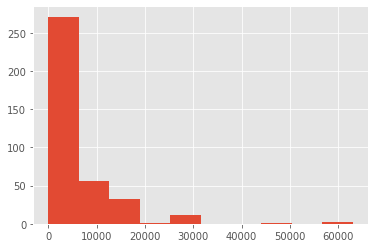

In [12]:
res_control_1.revenue.hist()
print(np.percentile(res_control_1.revenue, [90, 95, 99]))
# Не более 5% процентов пользователей совершали транзакции на суммы более чем 16611.4

In [13]:
res_control_1.query('revenue > 16611.4').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
277,892216461,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,1.0,1.0,64298.0
317,891383310,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,22,1000,NaN,Turkey,1,1,19,83,4,1.0,1.0,63037.0
143,892333905,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
30,892421277,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147.0,promo_09,premium_no_trial,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333.0
335,892333905,2017-10-16 01:38:00,2017-10-17 20:53:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
316,892333905,2017-10-16 01:38:00,2017-10-16 02:52:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
306,892333905,2017-10-16 01:38:00,2017-10-16 10:24:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
304,892333905,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
297,892333905,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
256,892333905,2017-10-16 01:38:00,2017-10-17 00:40:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


In [14]:
res_control_1.query('uid == 892333905')

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
6,892333905,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
13,892333905,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
28,892333905,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
43,892333905,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
47,892333905,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
49,892333905,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
63,892333905,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
76,892333905,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
88,892333905,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
126,892333905,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


Среди всех выделяются несколько пользователей, производивших транзакции на большие суммы.
Особенно пользователь "892333905", сделавший за двое суток 27 транзакций на суммы, значительно превышающие среднюю по контрольной группе.

In [15]:
round(res_control_1.query('uid == 892333905').revenue.sum() / res_control_1.revenue.sum()*100, 2)

18.62

Сумма транзакций пользователя '892333905' составляет 18.62% от всех транзакций первой контрольной группы.
Исключим его из датафрейма для сравнений транзакций.

In [16]:
res_control_1 = res_control_1.query('uid != 892333905')
res_control_1.shape[0]

350

[12682.8  12921.35 16941.47]


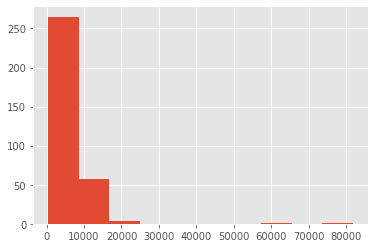

In [17]:
res_control_2.revenue.hist()
print(np.percentile(res_control_2.revenue, [90, 95, 99]))
# Не более 5% процентов пользователей совершали транзакции на суммы более чем 12921.35

In [18]:
res_control_2.query('revenue > 12921.35').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
47,891778551,2017-10-27 21:26:00,2017-10-27 22:30:00,81796,147,left_sidebar_menu,premium_no_trial,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,1.0,1.0,81796
22,892307238,2017-10-16 16:01:00,2017-10-16 20:41:00,63037,147,left_sidebar_menu,premium_no_trial,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,1.0,1.0,75647
97,891664350,2017-10-30 00:21:00,2017-03-11 02:57:00,19513,146,empty_likes,coins,34,242,271.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,17,41,541,1.0,1.0,28119
71,891328884,2017-05-11 17:44:00,2017-11-13 19:45:00,16952,147,trial_vip_popup,trial_premium,44,0,NaN,Italy,"1,2,4,5,7,8,9",1,41,47,0,1.0,1.0,16952
212,891950754,2017-10-24 06:24:00,2017-10-31 08:39:00,16913,147,left_sidebar_menu,trial_premium,34,151,NaN,Portugal,"1,2,3,5,7,9,10,11",1,16,56,33,1.0,1.0,16913
93,892215174,2017-10-18 15:17:00,2017-10-25 17:17:00,16835,147,trial_vip_popup,trial_premium,41,0,NaN,Belgium,1,1,38,44,4,1.0,1.0,16835
152,891436977,2017-03-11 20:48:00,2017-10-11 22:48:00,16666,147,trial_vip_popup,trial_premium,43,571,NaN,Spain,"1,2",1,23,36,7,1.0,1.0,16666
121,891962115,2017-10-23 22:53:00,2017-10-31 00:54:00,16653,147,trial_vip_popup,trial_premium,44,222,NaN,Spain,NaN,1,41,47,9,1.0,1.0,16653
323,891985866,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium,34,349,4.0,Belgium,"1,2,3,4,5,6,7,8,10,11,12,14,16,17,19,21,22",1,21,99,63,1.0,1.0,20605
313,891691062,2017-10-29 16:19:00,2017-05-11 18:35:00,16614,147,popular_users_block,trial_premium,30,0,NaN,Belgium,1,1,27,33,0,1.0,1.0,16614


Во второй контрольной группе подобных случаев не наблюдается.

Проведем A/A-тест повторно.

  0%|          | 0/1000 [00:00<?, ?it/s]

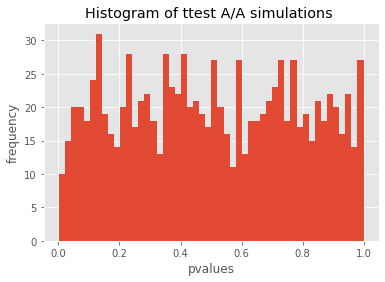

0.034

In [19]:
get_AA(res_control_1['revenue'],
       res_control_2['revenue'])

FPR < 0.05. Исключив пользователя "892333905", мы добились того, что А/А-тест "сошёлся".
Можно предположить, что причина найдена.

## 3. Сравнения контрольной группы №1 и тестовой группы

Рассчитаем:

- конверсию в платеж (Платящие пользователи / Новые пользователи):

In [20]:
round(res_control_1.uid.nunique() / users_control_1.uid.nunique() * 100, 2)

4.42

In [21]:
round(res_test.uid.nunique() / users_test.uid.nunique() * 100, 2)

3.39

Конверсию в дальнейшем предполагается использовать как дополнительную характеристику групп по ходу сравнений.

- cуммарную выручку по новым пользователям:

In [22]:
res_control_1.drop_duplicates(subset='uid').total_revenue.sum()
# сумма без аномального пользователя, до его исключения, контрольная группа превосходила тестовую.

2125201.0

In [23]:
res_test.drop_duplicates(subset='uid').total_revenue.sum()

2300818

- ARPU:

In [24]:
round(res_control_1.drop_duplicates(subset='uid').total_revenue.sum() / users_control_1.uid.nunique(), 2)

489.68

In [25]:
round(res_test.drop_duplicates(subset='uid').total_revenue.sum() / users_test.uid.nunique(), 2)

534.08

- средние и медианные значения в группах:

In [26]:
res_control_1.revenue.mean()

6074.231428571428

In [27]:
res_test.revenue.mean()

8589.380952380952

In [28]:
res_control_1.revenue.median()

5921.5

In [29]:
res_test.revenue.median()

6305.0

- Конверсия в платеж контрольной группы пользователей равна 4.42%, тестовой - 3.39%, количество новых пользователей - 4340 и 4308 соответственно.

- ARPU в тестовой группе незначительно выше.


- Общая нормированная выручка в тестовой группе превосходит выручку в контрольной (после исключения пользователя "892333905").


- Cредние и медианные значения транзакций выше в тестовой группе.


### 3.1. A/B-тест "revenue"

Для начала проверим на наличие аномалий в тестовой группе.

[13891.8  16621.8  35041.24]


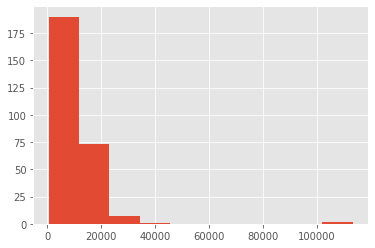

In [30]:
res_test.revenue.hist()
print(np.percentile(res_test.revenue, [90, 95, 99]))

In [31]:
res_test.query('revenue > 16621.8').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
12,891178380,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870
196,892038759,2017-10-22 11:12:00,2017-10-22 16:23:00,113477,147,autoreply_message,premium_no_trial,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565
64,892275462,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885
44,891346269,2017-05-11 12:55:00,2017-07-11 11:28:00,31525,19,empty_likes,coins,34,204,530.0,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
81,892236423,2017-10-18 01:09:00,2017-10-23 00:14:00,31525,19,menu,coins,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823
169,891914619,2017-10-24 23:12:00,2017-10-25 21:22:00,31525,19,empty_likes,coins,45,371,253.0,United States of America,"1,2,3,4",1,30,43,493,1.0,NaN,35308
202,891346269,2017-05-11 12:55:00,2017-07-11 11:27:00,31525,19,empty_likes,coins,34,204,530.0,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
216,892150854,2017-10-20 00:25:00,2017-10-30 02:14:00,31525,19,empty_likes,coins,38,329,204.0,Argentina,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789
259,892248561,2017-10-17 20:06:00,2017-10-18 20:35:00,31525,19,empty_likes,coins,22,106,192.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,26,198,1.0,1.0,38779
14,892150854,2017-10-20 00:25:00,2017-10-23 01:31:00,30264,68,super_popup,other_type,38,329,204.0,Argentina,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789


Явных аномалий не выявлено.

Проверим распределения на нормальность:

In [32]:
control = res_control_1.revenue
test = res_test.revenue

ShapiroResult(statistic=0.5871440768241882, pvalue=5.1500055232869805e-28)


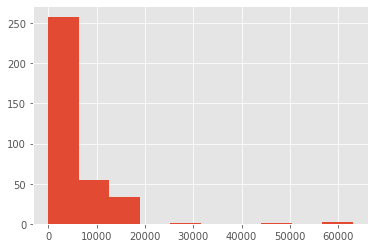

In [33]:
control.hist()
print(stats.shapiro(control))

ShapiroResult(statistic=0.4980769753456116, pvalue=3.996793050437411e-27)


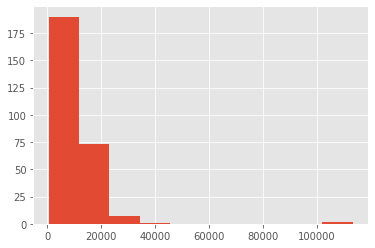

In [34]:
test.hist()
print(stats.shapiro(test))

Тест Шапиро-Уилка подтверждает, что распределения "revenue" контрольной и тестовых групп не являются нормальными.
Воспользуемся бутстрэпом. 

In [35]:
all_comparisons = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])

Определим гипотезы:
    
H0: Изменение стоимости премиум-подписки не повлияло на величины транзакций в контрольной и тестовой группах.

H1: Величины транзакций в контрольной и тестовой группах изменились вследствие изменения стоимости премиум-подписки.

In [36]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [37]:
boot_data_mean = get_bootstrap(test, control)

comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
p_value = boot_data_mean["p_value"]
ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
comparison = {'group': "revenue",
              'ci_0.025': ci_0025,
              'ci_0.0975': ci_0975,
              'p_value': p_value}

comparison_table = comparison_table.append([comparison])
        
# comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
all_comparisons = all_comparisons.append(comparison_table)
comparison_table

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,revenue,1248.976857,3960.0535,0.000297


Значение p-value меньше "0.05", результаты сравнения дают основания отклонить нулевую гипотезу.

Можно сделать вывод о статистически значимом различии величин между контрольной и тестовой группами,
а также о положительной разнице величин транзакций тестовой и контрольной групп.

** Здесь и далее все промежуточные выводы по результатам A/B-тестов основываются на скорректированном значении α. Полная таблица представлена в конце ноутбука.

### 3.2. A/B-тест "total_revenue"

Проверим, повлияло ли изменение стоимости премиум-подписки на величины нормированной выручки в контрольной и тестовой группах.

In [38]:
control = res_control_1.drop_duplicates(subset='uid').total_revenue  # чтобы total_revenue каждого пользователя попали в тест только один раз
test = res_test.drop_duplicates(subset='uid').total_revenue

comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
p_value = boot_data_mean["p_value"]
ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
comparison = {'group': 'total_revenue',
              'ci_0.025': ci_0025,
              'ci_0.0975': ci_0975,
              'p_value': p_value}

comparison_table = comparison_table.append([comparison])
        
# comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
all_comparisons = all_comparisons.append(comparison_table)
comparison_table

,group,ci_0.025,ci_0.0975,p_value
0,total_revenue,1248.976857,3960.0535,0.000297


Далее рассмотрим подгруппы пользователей, исходя из изменений в стоимости продуктов, а именно:
- пользователей пробной подписки (в тестовой группе стоимость не изменилась)
- премиум-подписки (в тестовой группе стоимость изменилась)


- подписки за внутреннюю валюту и "other".

In [39]:
def comparisons(groups):
    
    global all_comparisons
    comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
    
    for group in groups:
        control = (
            res_control_1
            .drop_duplicates(subset='uid')
            .query(group)
            .total_revenue
        )
        test = (
            res_test
            .drop_duplicates(subset='uid')
            .query(group)
            .total_revenue
        )
        boot_data_mean = get_bootstrap(test, control)
        p_value = boot_data_mean["p_value"]
        ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
        ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
        comparison = {'group': group,
                      'ci_0.025': ci_0025,
                      'ci_0.0975': ci_0975,
                      'p_value': p_value}

        comparison_table = comparison_table.append([comparison])
        
    # comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
    all_comparisons = all_comparisons.append(comparison_table)
    return comparison_table

In [40]:
groups = ['product_type == "trial_premium"',
          'product_type == "premium_no_trial"',
          'product_type == "coins"',
          'product_type == "other_type"']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,"product_type == ""trial_premium""",941.814453,3410.509375,0.000829
0,"product_type == ""premium_no_trial""",215.475000,10074.995290,0.050336
0,"product_type == ""coins""",-1990.307222,13206.375000,0.187370
0,"product_type == ""other_type""",2728.050000,34252.980357,0.030087


Результаты после применения поправки:

- Обнаружены статистически значимые различия между контрольной и тестовой группами. Судя по доверительным интервалам, можно сделать предположение о положительном влиянии нововведений на нормированную выручку по пользователям;

- Статистически значимые различия обнаружены только между пользователями контрольной и тестовой групп с пробной премиум-подпиской;

- Нет оснований отклонить нулевую гипотезу по нормированной выручке трех типов продукта: "premium_no_trial", "coins" и "other_type".

#### Промежуточный итог: 

В целом, можно судить об успешности эксперимента. Изменение стоимости премиум-подписки положительно сказалось на величинах транзакций и нормированной выручки в тестовой группе. Положительный эффект особенно заметен, учитывая, что коэффициент конверсии в плательщика в тестовой группе ниже, чем в контрольной.

## 4. Анализ влияния нововведений для конкретных групп пользователей.

In [41]:
res_control_1 = res_control_1.query('product_type == "trial_premium"')
res_test = res_test.query('product_type == "trial_premium"')

Разделим группы по следующим критериям и проведем сравнения:

1. Пол 
2. Возраст
3. Коэффициент привлекательности
4. Количество посещений приложения после регистрации

### 4.1. Пол

In [42]:
res_control_1.drop_duplicates(subset='uid').gender.value_counts()

1    63
0     4
Name: gender, dtype: int64

In [43]:
res_test.drop_duplicates(subset='uid').gender.value_counts()

1    59
0     2
Name: gender, dtype: int64

Делить и сравнивать пользователей по полу нет возможности, т.к. подавляющее большинство пользователей в группах относятся к гендеру "1". В большинстве случаев основной доход дейтинговым приложениям приносит мужская аудитория. Скорее всего, наш случай не стал исключением.

### 4.2. Возраст

Поделим пользователей по квартилям и сравним полученные группы между собой.

In [44]:
# исключил пользователей 99+, т.к. очень мала вероятность, что этот возраст достоверен

res_test.drop_duplicates(subset='uid').query('age < 99').age.quantile([0.25, 0.5, 0.75])

0.25    26.0
0.50    33.0
0.75    37.0
Name: age, dtype: float64

In [45]:
# исключил пользователей 99+, т.к. очень мала вероятность, что этот возраст достоверен
groups = ['age <= 26',
          'age >  26 and age <= 33',
          'age > 33 and age <= 37',
          'age > 37 and age < 99']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,age <= 26,2622.459211,9040.371053,0.000738
0,age > 26 and age <= 33,287.935870,6663.559783,0.044296
0,age > 33 and age <= 37,-281.479545,5091.302273,0.137158
0,age > 37 and age < 99,-1599.325000,3168.715789,0.491565


Стат.значимые различия при скорректированном значении alpha были обнаружены в возрастных группах "до 27 лет".
Величины нормированной выручки значимо различаются в пользу тестовой группы.

Рассчитаем коэффициент конверсии в платящего пользователя в подгруппах "27 лет".

In [46]:
def conversion_coeff(query1):
    coeff_control = round(res_control_1.drop_duplicates(subset='uid').query(query1).shape[0] /
                          users_control_1.drop_duplicates(subset='uid').query(query1).shape[0] * 100, 2)
    coeff_test = round(res_test.drop_duplicates(subset='uid').query(query1).shape[0] /
                       users_test.drop_duplicates(subset='uid').query(query1).shape[0] * 100, 2)
    print("conversion_control = ", coeff_control, "%", end="\n", sep="")
    print("conversion_test = ", coeff_test, "%", sep="")

In [47]:
conversion_coeff('age <= 26')

conversion_control = 1.26%
conversion_test = 1.07%


Коэффициент конверсии пользователей возраста "до 27 лет" в контрольной группе выше, чем в тестовой.

### 4.3 Коэффициент привлекательности

Как и в предыдущем пункте, для деления на подгруппы по коэффициенту привлекательности воспользуемся значениями квартилей тестовой группы пользователей.

In [48]:
res_test.drop_duplicates(subset='uid').attraction_coeff.quantile([0.25, 0.5, 0.75])

0.25    181.0
0.50    333.0
0.75    487.0
Name: attraction_coeff, dtype: float64

In [49]:
groups = ['attraction_coeff <= 181',
          'attraction_coeff > 181 and attraction_coeff <= 333',
          'attraction_coeff > 333 and attraction_coeff <= 487',
          'attraction_coeff > 487']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,attraction_coeff <= 181,2848.170000,9752.063750,0.000557
0,attraction_coeff > 181 and attraction_coeff <=...,-863.109000,5302.050000,0.196290
0,attraction_coeff > 333 and attraction_coeff <=...,219.851667,9993.771667,0.093194
0,attraction_coeff > 487,120.856667,3275.350000,0.032205


Величины нормированной выручки пользователей cо значением коэффициента привлекательности меньшим или равным 157 в контрольной и тестовой группах значимо различаются.

In [50]:
conversion_coeff('attraction_coeff <= 181')

conversion_control = 1.02%
conversion_test = 0.82%


Также, как и в случае с разделением по возрасту, значение коэффициента конверсии среди пользователей с  "attraction_coeff <= 181" в контрольной группе превосходит аналогичный показатель в тестовой.

### 4.4 Посещения после регистрации

Рассчитаем количество дней после регистрации, когда пользователь посещал приложение:

In [51]:
res_control_1['visit_days_count'] = res_control_1['visit_days'].str.split(",").str.len()
res_test['visit_days_count'] = res_test['visit_days'].str.split(",").str.len()
users_control_1['visit_days_count'] = users_control_1['visit_days'].str.split(",").str.len()
users_test['visit_days_count'] = users_test['visit_days'].str.split(",").str.len()

res_test.visit_days_count.isna().sum()
# есть пользователи, совершавшие транзакции, но посещения которых не зафиксированы

14

In [52]:
res_test.drop_duplicates(subset='uid').visit_days_count.quantile([0.25, 0.5, 0.75])

0.25     2.0
0.50     7.0
0.75    12.0
Name: visit_days_count, dtype: float64

In [53]:
groups = ['visit_days_count <= 2',
          'visit_days_count > 2 and visit_days_count <= 7',
          'visit_days_count > 7 and visit_days_count <= 12',
          'visit_days_count > 12']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,visit_days_count <= 2,-36.573333,2662.443333,0.055810
0,visit_days_count > 2 and visit_days_count <= 7,1252.464474,8646.864474,0.017593
0,visit_days_count > 7 and visit_days_count <= 12,-574.789583,6900.833333,0.093199
0,visit_days_count > 12,4657.389286,16274.932143,0.000750


Величины нормированной выручки среди наиболее активной части пользователей (13 и более дней посещений приложения после регистрации) в контрольной и тестовой группах значимо различаются в пользу тестовой.

In [54]:
conversion_coeff('visit_days_count > 12')

conversion_control = 2.64%
conversion_test = 2.23%


Значение коэффициента конверсии контрольной группы также превосходит аналогичный показатель в тестовой.

### Итоговая таблица всех сравнений

Воспользуемся поправками Холма-Бонферрони и Холма-Шидака для корректировки alpha в целях минимизации возможности получить ошибку первого рода при множественном сравнении средних:

In [56]:
all_comparisons['Holm-Bonferroni Correction Result'] = holm_bonferroni(all_comparisons.p_value, alpha = 0.05)

reject, p_value_corrected, sidak_corr, bonf_corr = multipletests(all_comparisons.p_value, alpha=0.05, method='Holm-Sidak')
all_comparisons['Holm-Sidak Correction Result'] = reject

all_comparisons

,group,ci_0.025,ci_0.0975,p_value,Holm-Bonferroni Correction Result,Holm-Sidak Correction Result
0,revenue,1248.976857,3960.053500,0.000297,True,True
0,total_revenue,1248.976857,3960.053500,0.000297,True,True
0,"product_type == ""trial_premium""",941.814453,3410.509375,0.000829,True,True
0,"product_type == ""premium_no_trial""",215.475000,10074.995290,0.050336,False,False
0,"product_type == ""coins""",-1990.307222,13206.375000,0.187370,False,False
0,"product_type == ""other_type""",2728.050000,34252.980357,0.030087,False,False
0,age <= 26,2622.459211,9040.371053,0.000738,True,True
0,age > 26 and age <= 33,287.935870,6663.559783,0.044296,False,False
0,age > 33 and age <= 37,-281.479545,5091.302273,0.137158,False,False
0,age > 37 and age < 99,-1599.325000,3168.715789,0.491565,False,False


## Подведем итоги

1. Был ли эксперимент успешен в целом?

В целом, можно судить об успешности эксперимента.
Нововведение положительно сказалось на нормированной выручке пользователей с пробной премиум-подпиской ("trial_premium"). Положительный эффект особенно заметен, учитывая, что коэффициент конверсии в плательщика и количество пользователей в тестовой группе ниже, чем в контрольной.

2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

A/B-тестирования дают основания полагать, что изменение стоимости премиум-подписки без пробного периода статистически значимо повлияло на следующие группы пользователей:

- наиболее активные пользователи (13 и более дней);
- пользователи молодого возраста до 27 лет;
- пользователи с коэффициентом привлекательности менее или равном 181.

Во всех этих группах замечено снижение конверсии пользователей в плательщиков после введения изменений в цену премиум-подписки. При этом сравнения тестовых и контрольных групп по указанным выше критериям говорят об увеличении нормированной выручки по пользователям в пользу тестовой.